In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

RENDER_HUMAN = False
if RENDER_HUMAN:
    env = gym.make('Pendulum-v1', render_mode="human")
else:
    env = gym.make('Pendulum-v1')

print("Action Space: ", env.action_space)
print("Obs Space: ", env.observation_space)


SEED = 2147483647
# SEED = 0

# torch.manual_seed(SEED)

Action Space:  Box(-2.0, 2.0, (1,), float32)
Obs Space:  Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


In [2]:
g = torch.Generator().manual_seed(SEED)

# Create NN Parameters
W1 = torch.randn((3,30), generator=g)  * 0.1
b1 = torch.randn((30), generator=g) *  0.01

W2 = torch.randn((30,4), generator=g) * 0.1
b2 = torch.randn((4), generator=g) * 0.01


params = [W1, b1, W2, b2]

for p in params:
    p.requires_grad = True
n_params = sum(p.numel() for p in params)

print("Network Params: ", n_params)

Network Params:  244


In [3]:
# Beacuse multiple layers, I need to scale the weight sizes other wise they are getting to big a maxing out my tanh:

# tensor([-12.4065,  13.5489,   3.1324,  -7.5802], grad_fn=<AddBackward0>)
# tensor([-1.0000,  1.0000,  0.9962, -1.0000], grad_fn=<TanhBackward0>)
# tensor(-1.0000, grad_fn=<SelectBackward0>) tensor(0.9064)
# tensor(1.7397e-06)
# tensor(1.2861e-06)
# tensor(-0.0001)
# tensor(-4.0906e-06)

In [4]:
#reward is usally between 0 and -16.2736044

max_reward = 0
min_reward = -16.2736044
avg_reward = (max_reward+min_reward)/2
spread = abs(max_reward - min_reward)

In [5]:
action = env.action_space.sample()  #first action is random

In [8]:
observation, info = env.reset(seed=SEED)

curr_obs_raw, info = env.reset(seed=SEED)
curr_obs = torch.tensor(curr_obs_raw) / torch.tensor([1, 1, 8])

losses = []  
time_steps = []  

for _ in range(1000):
    
    # Forward Pass, make prediction based on current state
    l1 = F.relu(curr_obs @ W1 + b1)
    output = l1 @ W2 + b2
    next_obs_pred = torch.tanh(output)

    # time step forward
    next_obs_raw, reward_raw, terminated, truncated, info = env.step(action)
    reward = (reward_raw - avg_reward) / (spread * 0.5)

    next_obs = torch.tensor(next_obs_raw) / torch.tensor([1, 1, 8])
    curr_obs = next_obs # reassign for next loop

    next_obs_with_reward = torch.cat((next_obs, torch.tensor([reward])), dim=0).float()

    # Backward pass - calculate prediction error + backprop
    # print(f"pred: {next_obs_pred[3]} actual: {next_obs_with_reward[3]}")

    # loss = F.mse_loss(next_obs_pred[3], next_obs_with_reward[3])
    loss = F.mse_loss(next_obs_pred, next_obs_with_reward)

    print(loss.item())
    losses.append(loss.item())
    time_steps.append(_)


    for p in params:
        p.grad = None

    loss.backward()

    for p in params:
        p.data += -0.05 * p.grad

    if terminated or truncated:
        curr_obs_raw, info = env.reset(seed=SEED)
        curr_obs = torch.tensor(curr_obs_raw) / torch.tensor([1, 1, 8])
        
env.close()

0.20055367052555084
0.18466481566429138
0.16421383619308472
0.14026623964309692
0.11445143818855286
0.08969487994909286
0.06945174187421799
0.05570481717586517
0.05196449160575867
0.060826390981674194
0.0805174931883812
0.10789951682090759
0.14608019590377808
0.19141894578933716
0.14086748659610748
0.104135662317276
0.08955554664134979
0.09102215617895126
0.0973706915974617
0.10206793993711472
0.10186100006103516
0.09760268777608871
0.09096772968769073
0.08728983998298645
0.093674436211586
0.1175842359662056
0.15994182229042053
0.2191120684146881
0.2185594141483307
0.17686419188976288
0.1395597755908966
0.11081813275814056
0.09711290895938873
0.09619820863008499
0.10257454216480255
0.11161033064126968
0.1208861768245697
0.12670667469501495
0.12679722905158997
0.12116359174251556
0.11047719419002533
0.09627654403448105
0.08041628450155258
0.0658513531088829
0.05488959699869156
0.04965808987617493
0.05185557156801224
0.06409913301467896
0.08366253972053528
0.10570104420185089
0.127737864

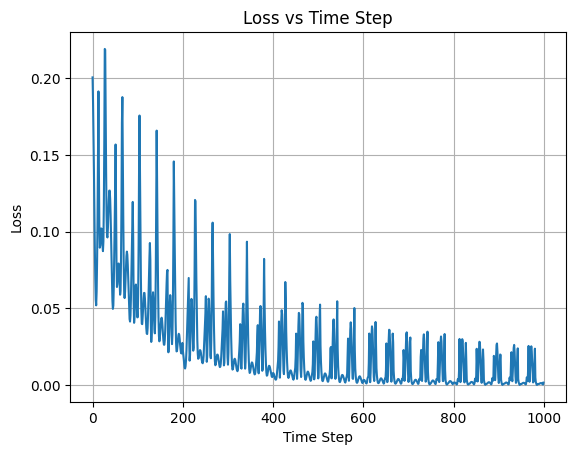

In [9]:

plt.plot(time_steps, losses, label='Raw Loss')

smooth_loss = np.convolve(losses, np.ones(200) / 200, mode='valid')
print(np.mean(smooth_loss))
plt.plot(time_steps[len(time_steps) - len(smooth_loss):], smooth_loss, label='Smoothed Loss')

plt.xlabel('Time Step')
plt.ylabel('Loss')
plt.title('Loss vs Time Step')
plt.grid(True)
plt.show()